<a href="https://colab.research.google.com/github/shubhu1026/AI-ML/blob/main/Final_Image_Processing_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip /content/archive.zip -d /content/dataset

Archive:  /content/archive.zip
  inflating: /content/dataset/README.md  
  inflating: /content/dataset/annotated-images/img-1.jpg  
  inflating: /content/dataset/annotated-images/img-1.xml  
  inflating: /content/dataset/annotated-images/img-10.jpg  
  inflating: /content/dataset/annotated-images/img-10.xml  
  inflating: /content/dataset/annotated-images/img-100.jpg  
  inflating: /content/dataset/annotated-images/img-100.xml  
  inflating: /content/dataset/annotated-images/img-101.jpg  
  inflating: /content/dataset/annotated-images/img-101.xml  
  inflating: /content/dataset/annotated-images/img-102.jpg  
  inflating: /content/dataset/annotated-images/img-102.xml  
  inflating: /content/dataset/annotated-images/img-103.jpg  
  inflating: /content/dataset/annotated-images/img-103.xml  
  inflating: /content/dataset/annotated-images/img-104.jpg  
  inflating: /content/dataset/annotated-images/img-104.xml  
  inflating: /content/dataset/annotated-images/img-105.jpg  
  inflating: /cont

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input
from tensorflow.keras.models import Model
import cv2
import glob
import json
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16

In [ ]:

# Load dataset splits
with open('/content/dataset/splits.json') as f:
    splits = json.load(f)


In [ ]:
# Load and preprocess images
def load_images(img_dir, img_filenames, img_size=(256, 256)):
    images = []
    for filename in img_filenames:
        img_path = os.path.join(img_dir, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        images.append(img / 255.0)
    return np.array(images)

In [ ]:
import os
import numpy as np
import xml.etree.ElementTree as ET

def load_masks(xml_dir, xml_filenames, img_size=(256, 256)):
    masks = []

    for xml_filename in xml_filenames:
        xml_path = os.path.join(xml_dir, xml_filename)
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Extract original image size from the XML
        original_width = int(root.find(".//size/width").text)
        original_height = int(root.find(".//size/height").text)

        # Initialize a blank mask for the target size
        mask = np.zeros(img_size, dtype=np.uint8)

        for obj in root.findall("object"):
            bbox = obj.find("bndbox")
            x_min, y_min, x_max, y_max = [int(bbox.find(tag).text) for tag in ["xmin", "ymin", "xmax", "ymax"]]

            x_min = int(x_min * img_size[0] / original_width)
            x_max = int(x_max * img_size[0] / original_width)
            y_min = int(y_min * img_size[1] / original_height)
            y_max = int(y_max * img_size[1] / original_height)

            mask[y_min:y_max, x_min:x_max] = 1

        masks.append(mask)

    return np.array(masks)


In [ ]:
# Load dataset splits from splits.json
def load_splits(splits_file):
    with open(splits_file, 'r') as f:
        splits = json.load(f)
    return splits['train'], splits['test']

# Paths to the dataset
img_dir = "/content/dataset/annotated-images"
xml_dir = "/content/dataset/annotated-images"
splits_file = "/content/dataset/splits.json"


In [ ]:
# Load train and test splits
train_filenames, test_filenames = load_splits(splits_file)

train_img_filenames = [f.replace(".xml", ".jpg") for f in train_filenames]
test_img_filenames = [f.replace(".xml", ".jpg") for f in test_filenames]

# Load train and test images and masks
X_train = load_images(img_dir, train_img_filenames)
Y_train = load_masks(xml_dir, train_filenames)

X_test = load_images(img_dir, test_img_filenames)
Y_test = load_masks(xml_dir, test_filenames)


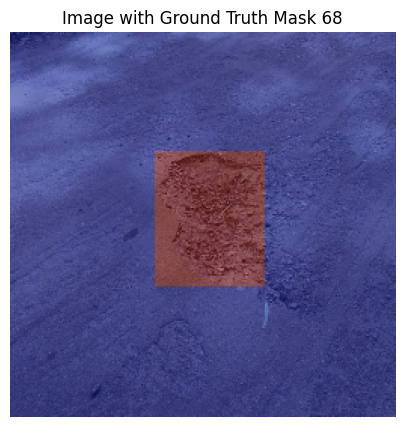

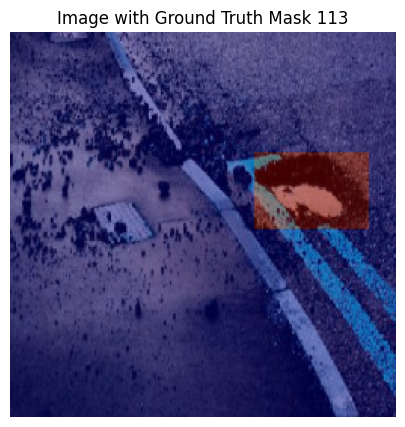

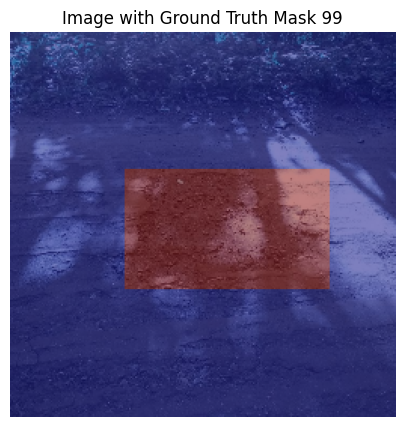

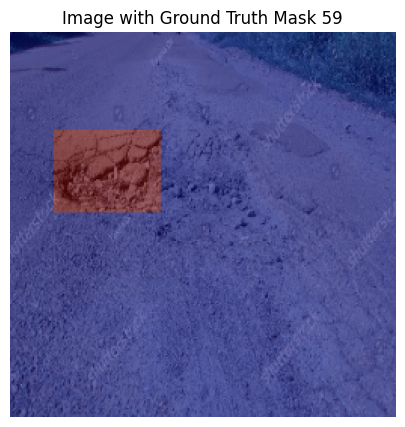

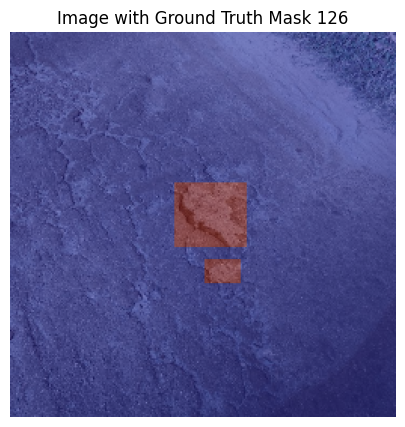

In [ ]:
import matplotlib.pyplot as plt
import random

random_indices = random.sample(range(len(X_test)), 5)

for i, idx in enumerate(random_indices):
    plt.figure(figsize=(10, 5))

    img = X_test[idx]

    mask = Y_test[idx].squeeze()

    plt.imshow(img)
    plt.imshow(mask, cmap="jet", alpha=0.5)

    plt.title(f"Image with Ground Truth Mask {idx+1}")
    plt.axis('off')

    plt.show()


In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(256, 256, 3)))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-5:]:
    layer.trainable = True

x = base_model.output
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(1, (1, 1), activation="sigmoid", padding="same")(x)

model = Model(inputs=base_model.input, outputs=x)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, Y_train, epochs=50, batch_size=8, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 434ms/step - accuracy: 0.8158 - loss: 0.5713 - val_accuracy: 0.8089 - val_loss: 0.3703
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.8330 - loss: 0.3252 - val_accuracy: 0.8552 - val_loss: 0.3191
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 0.8671 - loss: 0.3059 - val_accuracy: 0.8795 - val_loss: 0.2907
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 0.8928 - loss: 0.2532 - val_accuracy: 0.8609 - val_loss: 0.3293
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.9021 - loss: 0.2379 - val_accuracy: 0.8810 - val_loss: 0.2768
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.9217 - loss: 0.1934 - val_accuracy: 0.8881 - val_loss: 0.2761
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 0.9266 - loss: 0.1837 - val_accuracy: 0.8743 - val_loss: 0.2849
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.9289 - loss: 0.1768 - val_accuracy: 0.8889 

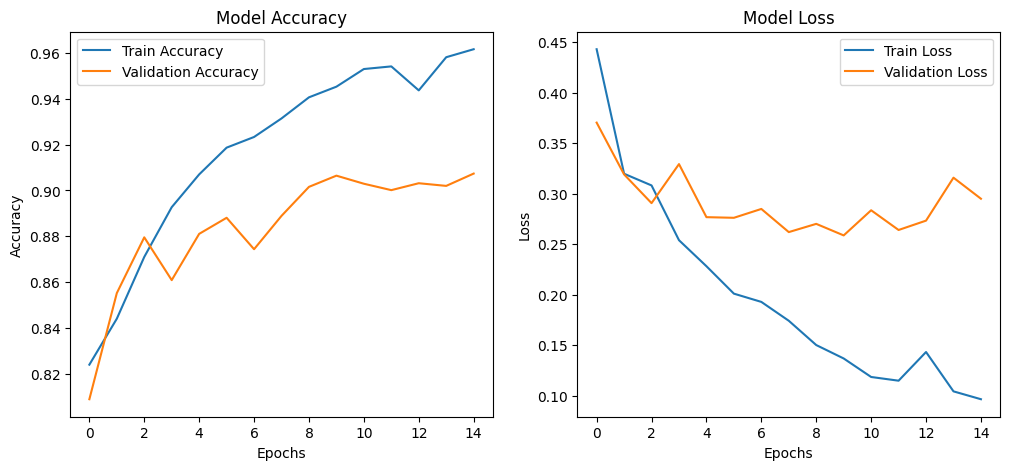

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test)

# Print the evaluation results
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9144 - loss: 0.2720
Test Loss: 0.25405153632164
Test Accuracy: 0.915986955165863


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(5, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step


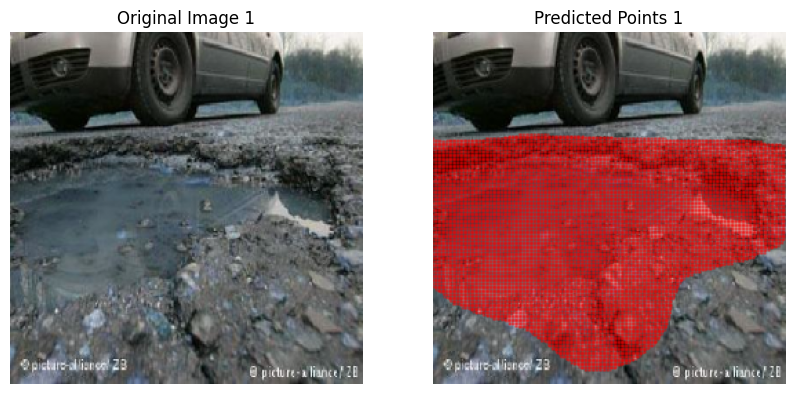

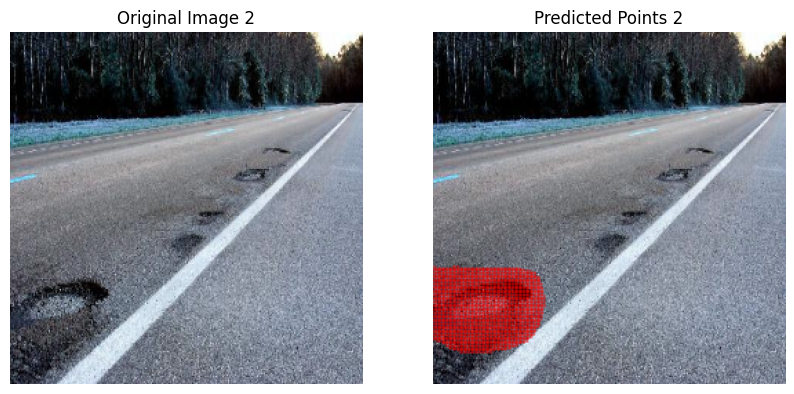

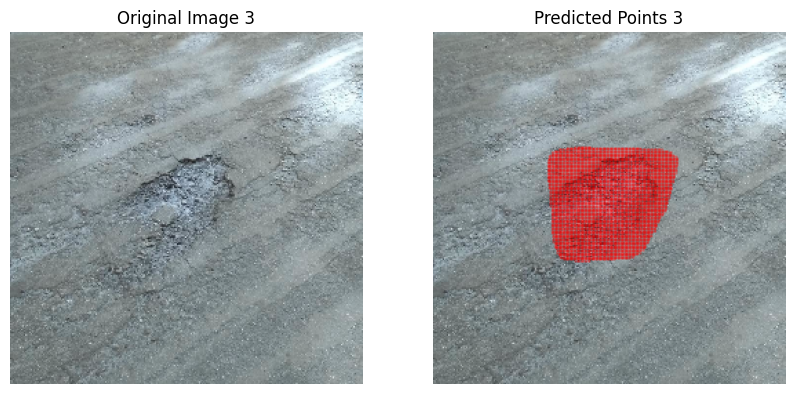

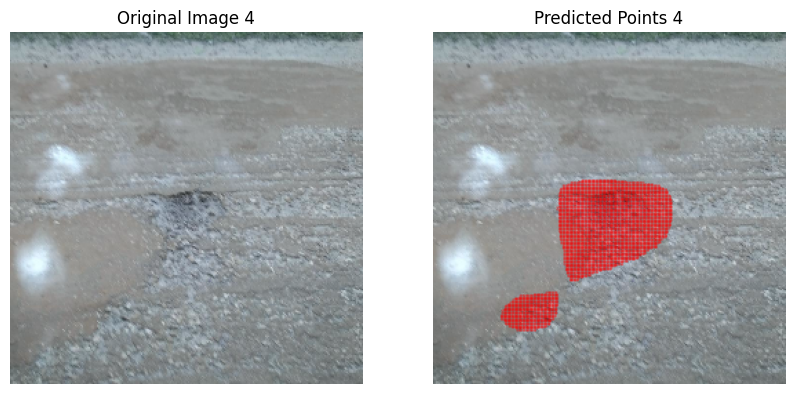

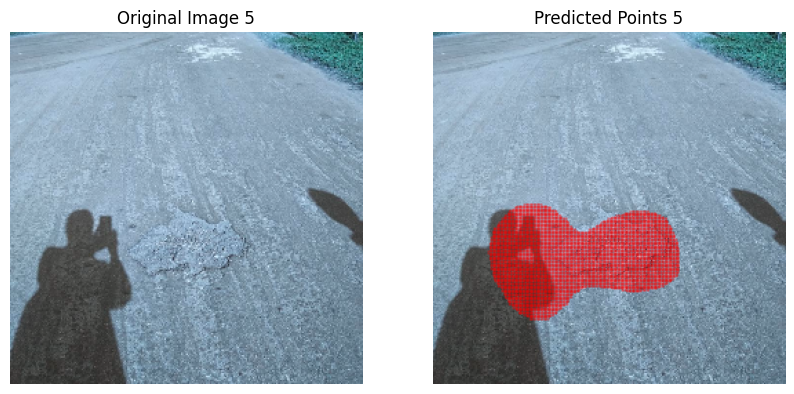

In [ ]:
predictions = model.predict(X_test[:5])

for i in range(5):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(X_test[i])
    plt.title(f"Original Image {i+1}")
    plt.axis('off')

    plt.subplot(1, 2, 2)

    pred_mask = predictions[i]

    pred_mask_resized = cv2.resize(pred_mask.squeeze(), (X_test[i].shape[1], X_test[i].shape[0]), interpolation=cv2.INTER_NEAREST)

    threshold = 0.3
    pred_mask_thresholded = (pred_mask_resized > threshold).astype(np.uint8)

    points = np.column_stack(np.where(pred_mask_thresholded > 0))


    plt.imshow(X_test[i])
    plt.scatter(points[:, 1], points[:, 0], color='red', s=1, alpha=0.2)
    plt.title(f"Predicted Points {i+1}")
    plt.axis('off')

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


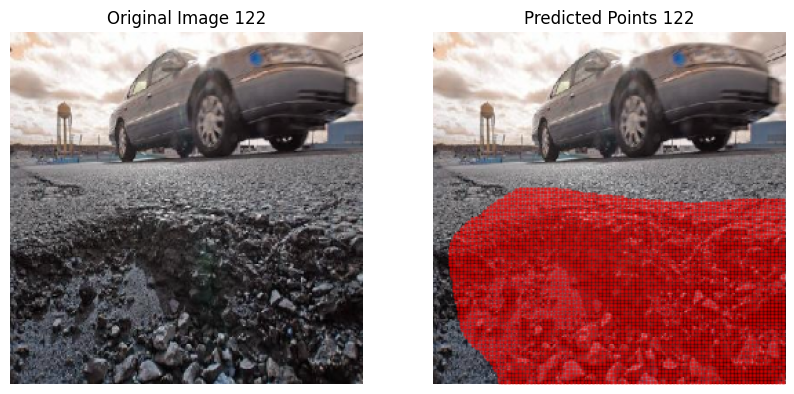

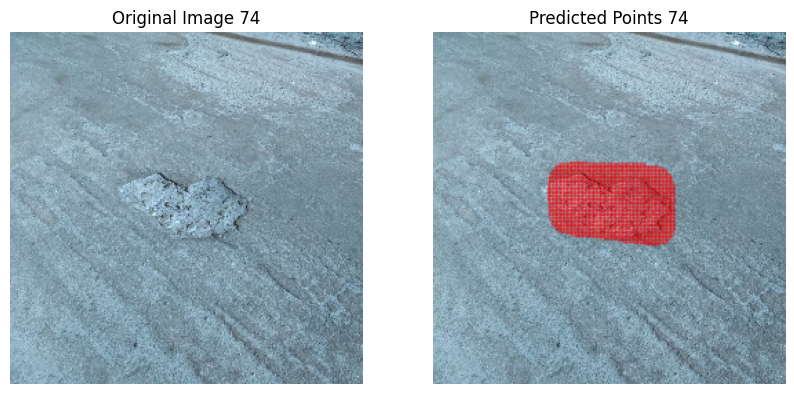

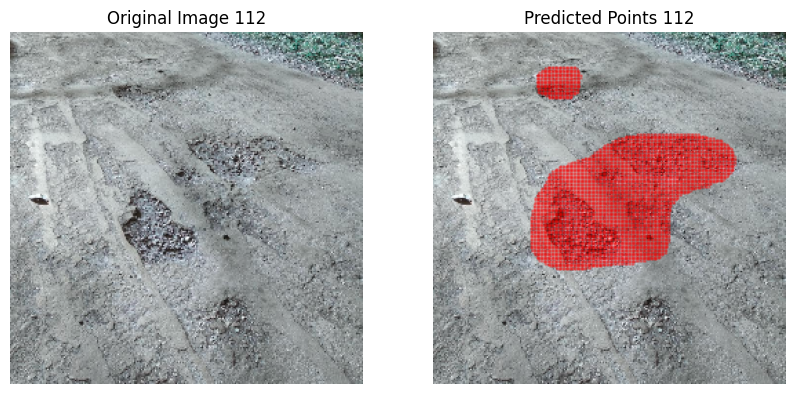

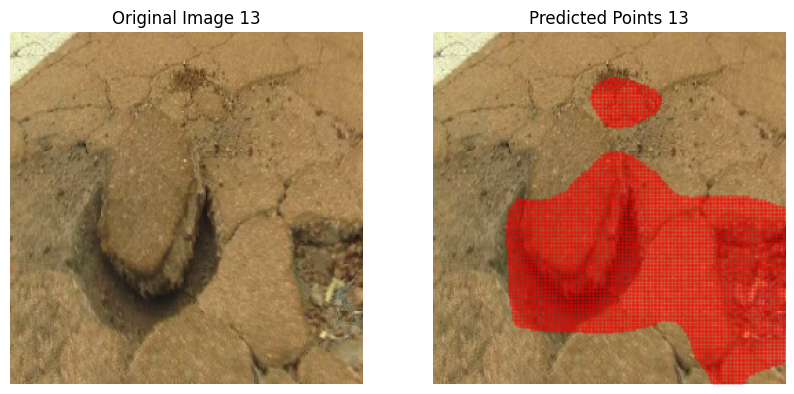

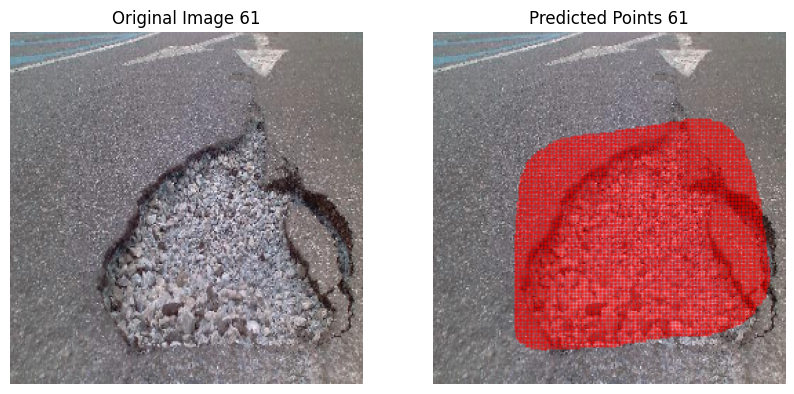

In [ ]:
import random


num_images = 5
random_indices = random.sample(range(len(X_test)), num_images)
predictions = model.predict(X_test[random_indices])

for i, idx in enumerate(random_indices):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(X_test[idx])
    plt.title(f"Original Image {idx+1}")
    plt.axis('off')

    plt.subplot(1, 2, 2)

    pred_mask = predictions[i]

    pred_mask_resized = cv2.resize(pred_mask.squeeze(), (X_test[idx].shape[1], X_test[idx].shape[0]), interpolation=cv2.INTER_NEAREST)

    threshold = 0.3
    pred_mask_thresholded = (pred_mask_resized > threshold).astype(np.uint8)

    points = np.column_stack(np.where(pred_mask_thresholded > 0))

    plt.imshow(X_test[idx])
    if points.size > 0:
        plt.scatter(points[:, 1], points[:, 0], color='red', s=1, alpha= 0.2)
    plt.title(f"Predicted Points {idx+1}")
    plt.axis('off')

    plt.show()
